<a href="https://colab.research.google.com/github/Camouflage10/bloom-comp/blob/main/bloom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install pycaret
!pip install pystac_client
!pip install planetary_computer
!pip install odc.stac

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 10.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.4/114.4 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 11.7 MB/s eta 0:00:00


In [ ]:
#imports
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split

In [ ]:
metadata=pd.read_csv('metadata.csv')
train_y=pd.read_csv('train_labels.csv')
submission=pd.read_csv('submission_format.csv')
metadata

,uid,latitude,longitude,date,split
0,aabm,39.080319,-86.430867,2018-05-14,train
1,aabn,36.559700,-121.510000,2016-08-31,test
2,aacd,35.875083,-78.878434,2020-11-19,train
3,aaee,35.487000,-79.062133,2016-08-24,train
4,aaff,38.049471,-99.827001,2019-07-23,train
...,...,...,...,...,...
23565,zzvv,36.708500,-121.749000,2014-12-02,test
23566,zzwo,39.792190,-99.971050,2017-06-19,train
23567,zzwq,35.794000,-79.012551,2015-03-24,train
23568,zzyb,35.742000,-79.238600,2016-11-21,train


In [ ]:
df=metadata.set_index('uid').join(train_y.set_index('uid'))
new = df["date"].str.split("-", expand = True)
df['year']=new[0].astype(int)
df['month']=new[1].astype(int)
df['day']=new[2].astype(int)
#add seasons based on month
df['season']=df['month']
df['season'].replace([1,11,12],value=4, inplace=True)
df['season'].replace([2,3,4],value=1, inplace=True)
df['season'].replace([5,6,7],value=2, inplace=True)
df['season'].replace([8,9,10], value=3, inplace=True)
df.reset_index(inplace=True)
df['region'].replace(['midwest', 'south', 'west', 'northeast'],
                        [0, 1, 2, 3], inplace=True)
submission['region'].replace(['midwest', 'south', 'west', 'northeast'],
                        [0, 1, 2, 3], inplace=True)

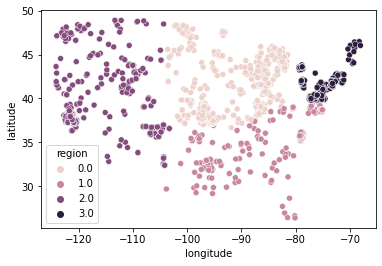

In [ ]:
sn.scatterplot('longitude', 'latitude', data=df, hue='region')

In [ ]:
#test train split
train = df[df['split']=='train']
train_x = pd.DataFrame(train, columns = [ 'latitude', 'longitude','region', 'year', 'month', 'day'])
train_y = pd.DataFrame(train, columns = ['severity'])
test = df[df['split']!='train']
test = test.drop(columns=df.columns[4:8])
test=test.set_index('uid').join(submission.set_index('uid'))
test_x = pd.DataFrame(test, columns = ['latitude', 'longitude','region', 'year', 'month', 'day'])

In [ ]:

sx_train, sx_test, sy_train, sy_test=train_test_split(train_x,train_y, train_size=.2,stratify=train_y)

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
hyperbag={'n_estimators': [100],'learning_rate': [.75,.1]}
boost = XGBClassifier()
boost_grid=GridSearchCV(boost,hyperbag, scoring='neg_root_mean_squared_error')
boost_grid.fit(sx_train,sy_train)
boost_pred=boost_grid.predict(sx_test)
boost_results=pd.DataFrame(boost_grid.cv_results_)
print(boost_grid.best_params_)
print(boost_grid.best_score_)
boost_results

{'learning_rate': 0.75, 'n_estimators': 100}
-0.8115108424267827


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.379918,0.039334,0.010994,0.000791,0.75,100,"{'learning_rate': 0.75, 'n_estimators': 100}",-0.812602,-0.770047,-0.823055,-0.845897,-0.805953,-0.811511,0.024767,1
1,0.360628,0.010989,0.009763,0.000788,0.1,100,"{'learning_rate': 0.1, 'n_estimators': 100}",-0.896553,-0.820670,-0.867294,-0.888176,-0.868983,-0.868335,0.026319,2


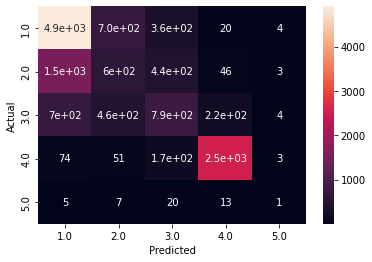

In [ ]:
sy_test=np.array(sy_test)
sy_test=np.reshape(sy_test,(len(sy_test),))
c_matrix = pd.crosstab(sy_test, boost_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(c_matrix, annot=True)
plt.show()

In [ ]:
test_x

,latitude,longitude,region,year,month,day
uid,,,,,,
aabn,36.559700,-121.510000,2,2016,8,31
aair,33.042600,-117.076000,2,2014,11,1
aajw,40.703968,-80.293050,3,2015,8,26
aalr,38.972500,-94.672930,0,2019,8,26
aalw,34.279000,-118.905000,2,2018,1,8
...,...,...,...,...,...,...
zzpn,40.136410,-80.473740,3,2019,7,8
zzrv,36.875400,-121.561000,2,2019,9,17
zzsx,34.210000,-78.929389,1,2019,7,16


In [ ]:
pred=boost_grid.predict(test_x)
test_x['severity']=pred.astype(int)
test_x.reset_index(inplace=True)
sub=pd.DataFrame(test_x, columns = ['uid', 'region', 'severity'])
sub['region'].replace([0,1,2,3],
                        ['midwest', 'south', 'west', 'northeast'], inplace=True)
sub

,uid,region,severity
0,aabn,west,4
1,aair,west,3
2,aajw,northeast,4
3,aalr,midwest,3
4,aalw,west,3
...,...,...,...
6505,zzpn,northeast,5
6506,zzrv,west,4
6507,zzsx,south,2
6508,zzvv,west,4


In [ ]:
sub.to_csv('submission.csv', index=False)